In [57]:
# Install necessary libraries
!pip install lightgbm
!pip install prophet

# Standard libraries
import os  # For file operations
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis

# Visualization libraries
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical data visualization

# Machine Learning utilities
from sklearn.model_selection import train_test_split  # For splitting data into training and validation sets
from sklearn.preprocessing import LabelEncoder  # For encoding categorical features
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For evaluating model performance

# LightGBM for demand forecasting
import lightgbm as lgb  
from lightgbm import early_stopping, log_evaluation, LGBMRegressor  # Specific functions for training

# Prophet for time series forecasting
from prophet import Prophet  # Facebook's Prophet model for demand forecasting

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML  # For displaying HTML content in Jupyter notebooks


In [58]:
#Load the csv data files

offline_sales = pd.read_csv('datasets/sales.csv')
online_sales = pd.read_csv('datasets/online.csv')
actual_matrix = pd.read_csv('datasets/actual_matrix.csv')
discounts_history = pd.read_csv('datasets/discounts_history.csv')
markdowns = pd.read_csv('datasets/markdowns.csv')
price_history = pd.read_csv('datasets/price_history.csv')
stores = pd.read_csv('datasets/stores.csv')
catalog = pd.read_csv('datasets/translated_dataset.csv')

## Data Understanding

### Dataset Description  

This dataset contains sales information from four stores of a retailer over 25 months.  
Participants must develop models to predict customer demand. A holdout sample with sales data for one month is also included for forecasting.  

---

## 1. `sales.csv`  
**Purpose:** Aggregated store sales data for specific dates.  
**Columns:**  
- `date` - Sales date  
- `item_id` - Unique product identifier  
- `quantity` - Total quantity sold per day  
- `price_base` - Average sales price per day  
- `sum_total` - Total daily sales amount  
- `store_id` - Store number  

---

## 2. `online.csv`  
**Purpose:** Aggregated online sales data for specific dates.  
**Columns:**  
- `date` - Sales date  
- `item_id` - Unique product identifier  
- `quantity` - Total online sales per day  
- `price_base` - Average online sales price per day  
- `sum_total` - Total daily online sales amount  
- `store_id` - Store number  

---

## 3. `markdowns.csv`  
**Purpose:** Data on products sold at markdown prices.  
**Columns:**  
- `date` - Date of markdown  
- `item_id` - Unique product identifier  
- `normal_price` - Regular price  
- `price` - Markdown price  
- `quantity` - Quantity sold at markdown  
- `store_id` - Store number  

---

## 4. `price_history.csv`  
**Purpose:** Price changes in each store.  
**Columns:**  
- `date` - Date of price change  
- `item_id` - Unique product identifier  
- `price` - New item price  
- `code` - Price change code  
- `store_id` - Store number  

---

## 5. `discounts_history.csv`  
**Purpose:** Historical promo data per store.  
**Columns:**  
- `date` - Date  
- `item_id` - Unique product identifier  
- `sale_price_before_promo` - Price before promo  
- `sale_price_time_promo` - Price during promo  
- `promo_type_code` - Promo type code  
- `doc_id` - Promo document number  
- `number_disc_day` - Sequential day number in promo period  
- `store_id` - Store number  

---

## 6. `actual_matrix.csv`  
**Purpose:** List of products available in stores.  
**Columns:**  
- `item_id` - Unique product identifier  
- `date` - Date of last product appearance in matrix  
- `store_id` - Store number  

---

## 7. `catalog.csv`  
**Purpose:** Product catalog with characteristics.  
**Columns:**  
- `item_id` - Unique product identifier  
- `dept_name` - Product department  
- `class_name` - Product class  
- `subclass_name` - Product subclass  
- `item_type` - Product type  
- `weight_volume` - Volumetric weight  
- `weight_netto` - Net weight  
- `fatness` - Fat content  

---

## 8. `stores.csv`  
**Purpose:** Store information.  
**Columns:**  
- `store_id` - Store number  
- `division` - Store division  
- `format` - Store format  
- `city` - Store location  
- `area` - Sales area  

---

## 9. `test.csv`  
**Purpose:** Contains test cases for forecasting.  
**Columns:**  
- `row_id` - Unique identifier  
- `item_id` - Unique product identifier  
- `store_id` - Store number  
- `date` - Forecast date  

---

## 10. `sample_submission.csv`  
**Purpose:** Sample submission format.  
**Columns:**  
- `row_id` - Unique identifier  
- `quantity` - Predicted quantity (default: 0)  


### Exploring the Datasets
We first examine the datasets individually to understand their structure, missing values, and basic statistics

In [59]:
# Basic information about the datasets
def explore_data(df, name):
    print(f"Dataframe: {name}\n")
    print("Shape:", df.shape, "\n")
    
    print("First 5 Rows:")
    display(df.head())  # Display first 5 rows
    
    print("\nData Info:")
    df.info()
    
    print("\nSummary Statistics:")
    display(df.describe(include='all'))  # Display summary statistics
    
    print("\nMissing Values:")
    display(df.isnull().sum())  # Display missing values
    
    print("-" * 80, "\n\n")

# A loop to display basic information about all dataframes
dataframes = {
    "offline_sales": offline_sales, "online_sales": online_sales, "actual_matrix": actual_matrix,
    "discounts_history": discounts_history, "markdowns": markdowns, "price_history": price_history,
    "stores": stores, "catalog": catalog
}

for name, df in dataframes.items():
    explore_data(df, name)


Dataframe: offline_sales

Shape: (7432685, 7) 

First 5 Rows:


,Unnamed: 0,date,item_id,quantity,price_base,sum_total,store_id
0,0,2023-08-04,293375605257,1.000,47.86,47.86,1
1,1,2023-08-04,a66fdf2c0ae7,3.000,49.60,148.80,1
2,2,2023-08-04,daa46ef49b7a,0.822,379.00,311.54,1
3,3,2023-08-04,a3b49c1bf758,1.000,129.00,129.00,1
4,4,2023-08-04,ab611c5cef62,7.000,79.90,559.30,1



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7432685 entries, 0 to 7432684
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   date        object 
 2   item_id     object 
 3   quantity    float64
 4   price_base  float64
 5   sum_total   float64
 6   store_id    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 396.9+ MB

Summary Statistics:


,Unnamed: 0,date,item_id,quantity,price_base,sum_total,store_id
count,7.432685e+06,7432685,7432685,7.432685e+06,7.432685e+06,7.432685e+06,7.432685e+06
unique,NaN,761,28182,NaN,NaN,NaN,NaN
top,NaN,2023-12-30,e5b2b6f57ea7,NaN,NaN,NaN,NaN
freq,NaN,16410,2571,NaN,NaN,NaN,NaN
mean,1.235202e+07,NaN,NaN,5.642398e+00,2.075824e+02,7.612796e+02,2.041405e+00
std,7.625496e+06,NaN,NaN,2.740466e+01,3.372886e+02,4.789478e+03,1.206728e+00
min,0.000000e+00,NaN,NaN,-5.000000e+02,-2.167667e+04,-2.041080e+04,1.000000e+00
25%,1.858171e+06,NaN,NaN,1.000000e+00,6.000000e+01,1.279000e+02,1.000000e+00
50%,1.344877e+07,NaN,NaN,2.000000e+00,1.099000e+02,2.596000e+02,2.000000e+00
75%,1.988142e+07,NaN,NaN,4.672000e+00,1.999000e+02,5.990000e+02,3.000000e+00



Missing Values:


Unnamed: 0    0
date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

-------------------------------------------------------------------------------- 


Dataframe: online_sales

Shape: (1123412, 7) 

First 5 Rows:


,Unnamed: 0,date,item_id,quantity,price_base,sum_total,store_id
0,0,2023-08-04,4aa8dbe05246,3.0,12.40,37.21,1
1,1,2023-08-04,4e0fbcf99cf9,2.0,56.27,112.54,1
2,2,2023-08-04,2e008b673129,2.0,56.27,112.54,1
3,3,2023-08-04,49db9c973903,1.0,29.94,29.94,1
4,4,2023-08-04,9d6072422e8e,1.0,80.10,80.10,1



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1123412 entries, 0 to 1123411
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1123412 non-null  int64  
 1   date        1123412 non-null  object 
 2   item_id     1123412 non-null  object 
 3   quantity    1123412 non-null  float64
 4   price_base  1123412 non-null  float64
 5   sum_total   1123412 non-null  float64
 6   store_id    1123412 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 60.0+ MB

Summary Statistics:


,Unnamed: 0,date,item_id,quantity,price_base,sum_total,store_id
count,1.123412e+06,1123412,1123412,1.123412e+06,1.123412e+06,1.123412e+06,1.123412e+06
unique,NaN,761,18405,NaN,NaN,NaN,NaN
top,NaN,2024-04-06,a162df3be29c,NaN,NaN,NaN,NaN
freq,NaN,2688,1047,NaN,NaN,NaN,NaN
mean,1.295207e+06,NaN,NaN,2.194757e+00,1.497957e+02,2.259123e+02,1.659448e+00
std,8.939419e+05,NaN,NaN,3.879657e+00,2.193683e+02,4.205360e+02,1.242366e+00
min,0.000000e+00,NaN,NaN,2.000000e-03,-8.458330e+03,-3.418800e+02,1.000000e+00
25%,2.808528e+05,NaN,NaN,1.000000e+00,4.334000e+01,6.148000e+01,1.000000e+00
50%,1.789196e+06,NaN,NaN,1.000000e+00,7.869500e+01,1.109600e+02,1.000000e+00
75%,2.070048e+06,NaN,NaN,2.000000e+00,1.692625e+02,2.229000e+02,1.000000e+00



Missing Values:


Unnamed: 0    0
date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

-------------------------------------------------------------------------------- 


Dataframe: actual_matrix

Shape: (35202, 4) 

First 5 Rows:


,Unnamed: 0,item_id,date,store_id
0,0,c578da8e8841,2019-10-17,1
1,1,4dd2b686802c,2019-10-17,1
2,2,16ade2e3fca9,2019-10-17,1
3,3,f4eb16dab09e,2019-10-17,1
4,4,ab1384c2af6d,2020-05-31,1



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35202 entries, 0 to 35201
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  35202 non-null  int64 
 1   item_id     35202 non-null  object
 2   date        35202 non-null  object
 3   store_id    35202 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB

Summary Statistics:


,Unnamed: 0,item_id,date,store_id
count,35202.000000,35202,35202,35202.000000
unique,NaN,15398,1325,NaN
top,NaN,c578da8e8841,2023-12-13,NaN
freq,NaN,4,9793,NaN
mean,17600.500000,NaN,NaN,2.465599
std,10162.086425,NaN,NaN,1.346344
min,0.000000,NaN,NaN,1.000000
25%,8800.250000,NaN,NaN,1.000000
50%,17600.500000,NaN,NaN,2.000000
75%,26400.750000,NaN,NaN,4.000000



Missing Values:


Unnamed: 0    0
item_id       0
date          0
store_id      0
dtype: int64

-------------------------------------------------------------------------------- 


Dataframe: discounts_history

Shape: (3746744, 9) 

First 5 Rows:


,Unnamed: 0,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
0,3648316,2022-08-28,cde97a9ec3ef,729.9,669.9,6.0,89ea9f0c-1c08-11ed-ad4d-005056861040,13.0,1
1,3648317,2022-08-28,2906fbc9e11c,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1
2,3648318,2022-08-28,c48c3a3d8c01,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1
3,3648319,2022-08-28,f85243ca61e6,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1
4,3648320,2022-08-28,27ce75534065,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746744 entries, 0 to 3746743
Data columns (total 9 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   date                     object 
 2   item_id                  object 
 3   sale_price_before_promo  float64
 4   sale_price_time_promo    float64
 5   promo_type_code          float64
 6   doc_id                   object 
 7   number_disc_day          float64
 8   store_id                 int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 257.3+ MB

Summary Statistics:


,Unnamed: 0,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
count,3.746744e+06,3746744,3746744,3.746744e+06,3.746744e+06,3.428898e+06,3746744,3.746744e+06,3.746744e+06
unique,NaN,8527,16081,NaN,NaN,NaN,13763,NaN,NaN
top,NaN,2024-05-06,8250099a8aff,NaN,NaN,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,NaN,NaN
freq,NaN,7404,34108,NaN,NaN,NaN,196121,NaN,NaN
mean,7.227914e+06,NaN,NaN,4.253020e+02,3.340184e+02,5.662295e+00,NaN,2.863346e+02,2.034975e+00
std,2.790196e+06,NaN,NaN,6.575774e+02,5.133992e+02,1.858387e+00,NaN,1.179529e+03,1.159682e+00
min,3.648316e+06,NaN,NaN,0.000000e+00,0.000000e+00,1.000000e+00,NaN,1.000000e+00,1.000000e+00
25%,4.585002e+06,NaN,NaN,8.490000e+01,6.990000e+01,5.000000e+00,NaN,4.000000e+00,1.000000e+00
50%,7.522214e+06,NaN,NaN,1.799000e+02,1.499000e+02,5.000000e+00,NaN,8.000000e+00,2.000000e+00
75%,1.047746e+07,NaN,NaN,4.999000e+02,3.899000e+02,6.000000e+00,NaN,1.300000e+01,3.000000e+00



Missing Values:


Unnamed: 0                      0
date                            0
item_id                         0
sale_price_before_promo         0
sale_price_time_promo           0
promo_type_code            317846
doc_id                          0
number_disc_day                 0
store_id                        0
dtype: int64

-------------------------------------------------------------------------------- 


Dataframe: markdowns

Shape: (8979, 7) 

First 5 Rows:


,Unnamed: 0,date,item_id,normal_price,price,quantity,store_id
0,0,2023-08-01,bc2f82a22e11,189.0,100.0,8.0,1
1,1,2023-08-01,389412076801,179.0,100.0,5.0,1
2,2,2023-08-01,0e39cf5d57c1,149.0,100.0,5.0,1
3,3,2023-08-01,dd94e2bc5601,149.0,100.0,1.0,1
4,4,2023-08-01,e60d890f2812,369.0,270.0,1.0,1



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8979 entries, 0 to 8978
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    8979 non-null   int64  
 1   date          8979 non-null   object 
 2   item_id       8979 non-null   object 
 3   normal_price  8979 non-null   float64
 4   price         8979 non-null   float64
 5   quantity      8979 non-null   float64
 6   store_id      8979 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 491.2+ KB

Summary Statistics:


,Unnamed: 0,date,item_id,normal_price,price,quantity,store_id
count,8979.000000,8979,8979,8979.000000,8979.000000,8979.000000,8979.000000
unique,NaN,729,313,NaN,NaN,NaN,NaN
top,NaN,2023-09-03,e7ff6ea67040,NaN,NaN,NaN,NaN
freq,NaN,48,491,NaN,NaN,NaN,NaN
mean,18744.353269,NaN,NaN,358.352823,213.296578,3.070545,1.912797
std,11803.655972,NaN,NaN,220.119491,141.789922,4.236914,1.045986
min,0.000000,NaN,NaN,0.000000,12.500000,0.115000,1.000000
25%,15252.500000,NaN,NaN,189.000000,100.000000,1.000000,1.000000
50%,17497.000000,NaN,NaN,239.000000,150.000000,2.000000,2.000000
75%,28858.500000,NaN,NaN,549.000000,330.000000,4.000000,2.000000



Missing Values:


Unnamed: 0      0
date            0
item_id         0
normal_price    0
price           0
quantity        0
store_id        0
dtype: int64

-------------------------------------------------------------------------------- 


Dataframe: price_history

Shape: (698626, 6) 

First 5 Rows:


,Unnamed: 0,date,item_id,price,code,store_id
0,0,2023-08-01,4a1f95fe4d4b,499.9,1,1
1,1,2023-08-01,bf43a9d3ae13,0.0,9999999999,1
2,2,2023-08-01,0dd8744decce,129.9,1,1
3,3,2023-08-01,9b38c7e4dba9,136.0,1,1
4,4,2023-08-01,b791e8c9347c,0.0,1,1



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698626 entries, 0 to 698625
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  698626 non-null  int64  
 1   date        698626 non-null  object 
 2   item_id     698626 non-null  object 
 3   price       698626 non-null  float64
 4   code        698626 non-null  int64  
 5   store_id    698626 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 32.0+ MB

Summary Statistics:


,Unnamed: 0,date,item_id,price,code,store_id
count,6.986260e+05,698626,698626,6.986260e+05,6.986260e+05,698626.000000
unique,NaN,761,37624,NaN,NaN,NaN
top,NaN,2023-08-02,f1749f4b783b,NaN,NaN,NaN
freq,NaN,4934,559,NaN,NaN,NaN
mean,9.916036e+05,NaN,NaN,6.737037e+02,5.518547e+08,1.970169
std,6.403421e+05,NaN,NaN,2.013703e+05,2.283421e+09,1.098378
min,0.000000e+00,NaN,NaN,0.000000e+00,1.000000e+00,1.000000
25%,6.486332e+05,NaN,NaN,6.590000e+01,1.000000e+00,1.000000
50%,1.061548e+06,NaN,NaN,1.499000e+02,1.000000e+01,2.000000
75%,1.626984e+06,NaN,NaN,3.599000e+02,2.900000e+01,3.000000



Missing Values:


Unnamed: 0    0
date          0
item_id       0
price         0
code          0
store_id      0
dtype: int64

-------------------------------------------------------------------------------- 


Dataframe: stores

Shape: (4, 6) 

First 5 Rows:


,Unnamed: 0,store_id,division,format,city,area
0,0,4,Div1,MaxiEuro,City3,1887
1,1,3,Div2,Format-7 express,City2,109
2,2,2,Div2,Format-6,City1,210
3,3,1,Div1,Format-1,City1,1500



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4 non-null      int64 
 1   store_id    4 non-null      int64 
 2   division    4 non-null      object
 3   format      4 non-null      object
 4   city        4 non-null      object
 5   area        4 non-null      int64 
dtypes: int64(3), object(3)
memory usage: 320.0+ bytes

Summary Statistics:


,Unnamed: 0,store_id,division,format,city,area
count,4.000000,4.000000,4,4,4,4.000000
unique,NaN,NaN,2,4,3,NaN
top,NaN,NaN,Div1,MaxiEuro,City1,NaN
freq,NaN,NaN,2,1,2,NaN
mean,1.500000,2.500000,NaN,NaN,NaN,926.500000
std,1.290994,1.290994,NaN,NaN,NaN,900.581479
min,0.000000,1.000000,NaN,NaN,NaN,109.000000
25%,0.750000,1.750000,NaN,NaN,NaN,184.750000
50%,1.500000,2.500000,NaN,NaN,NaN,855.000000
75%,2.250000,3.250000,NaN,NaN,NaN,1596.750000



Missing Values:


Unnamed: 0    0
store_id      0
division      0
format        0
city          0
area          0
dtype: int64

-------------------------------------------------------------------------------- 


Dataframe: catalog

Shape: (219810, 10) 

First 5 Rows:


,Unnamed: 0,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness,class_name_en
0,0,da17e2d5feda,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,БУМАЖНАЯ ПРОДУКЦИЯ,ВЛАЖНЫЕ САЛФЕТКИ,NaN,150.0,NaN,NaN,BUMAGE PRODUCE
1,1,614de2b96018,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.0,NaN,NaN,PETROLEUM PRODUCE
2,2,0c1f1f3e3e11,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,NaN,NaN,NaN,PETROLEUM PRODUCE
3,3,71a7fa99f005,ТОВАРЫ ДЛЯ ДОМА,ПОСУДА,КУХОННАЯ ПОСУДА,NaN,NaN,NaN,NaN,BUILDING
4,4,ec1bd4d59fe9,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,ВАТНАЯ ПРОДУКЦИЯ,ВАТНЫЕ ДИСКИ,NaN,30.0,NaN,NaN,PETROLEUM PRODUCE



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219810 entries, 0 to 219809
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     219810 non-null  int64  
 1   item_id        219810 non-null  object 
 2   dept_name      219810 non-null  object 
 3   class_name     219810 non-null  object 
 4   subclass_name  219810 non-null  object 
 5   item_type      43586 non-null   object 
 6   weight_volume  82952 non-null   float64
 7   weight_netto   48957 non-null   float64
 8   fatness        7212 non-null    float64
 9   class_name_en  219810 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 16.8+ MB

Summary Statistics:


,Unnamed: 0,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness,class_name_en
count,219810.000000,219810,219810,219810,219810,43586,82952.000000,48957.000000,7212.000000,219810
unique,NaN,219810,196,613,1007,673,NaN,NaN,NaN,571
top,NaN,da17e2d5feda,ТОВАРЫ ДЛЯ ДОМА,ВИНА ТИХИЕ,ОТ ПРОИЗВОДИТЕЛЯ,Светлое,NaN,NaN,NaN,THOSE BLOCKS
freq,NaN,1,13600,8691,11944,1092,NaN,NaN,NaN,8691
mean,109905.205800,NaN,NaN,NaN,NaN,NaN,2.905660,0.768282,15.441335,NaN
std,63454.185328,NaN,NaN,NaN,NaN,NaN,33.890114,35.443477,23.182526,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,0.000010,-0.650000,0.030000,NaN
25%,54952.250000,NaN,NaN,NaN,NaN,NaN,0.200000,0.100000,2.500000,NaN
50%,109905.500000,NaN,NaN,NaN,NaN,NaN,0.450000,0.230000,3.600000,NaN
75%,164857.750000,NaN,NaN,NaN,NaN,NaN,0.750000,0.500000,20.000000,NaN



Missing Values:


Unnamed: 0            0
item_id               0
dept_name             0
class_name            0
subclass_name         0
item_type        176224
weight_volume    136858
weight_netto     170853
fatness          212598
class_name_en         0
dtype: int64

-------------------------------------------------------------------------------- 




## General Observations of the Data
    1.Negative values in the sales columns (quantity, priceBase, sum_total) Action: Drop rows
    2.Covert date column for all dataframes into date_time
    3.introduce a column called source in the sales data
    4.merge online_sales and offline_sales as they have the same column names




### Converting Date Columns to Datetime Format
Since sales data is time-dependent, we ensure all date columns are in the correct datetime format.

In [60]:
# Convert date columns in the dataframes into datetime format
def convert_date(df, column):
    df[column] = pd.to_datetime(df[column])
    return df

# Convert the 'date' column in all relevant dataframes
for name in ["offline_sales", "online_sales", "actual_matrix", "discounts_history", "markdowns", "price_history"]:
    globals()[name] = convert_date(globals()[name], "date")


### Processing and Merging Sales Data
We clean and merge offline and online sales into a single dataset, `gold_sales`

In [61]:
def process_and_merge_sales_data(offline_sales, online_sales):
    # Drop unnecessary column
    offline_sales = offline_sales.drop(columns=["Unnamed: 0"], errors='ignore')
    online_sales = online_sales.drop(columns=["Unnamed: 0"], errors='ignore')

    # Add source column to distinguish online and offline sales
    offline_sales["source"] = "offline"
    online_sales["source"] = "online"
    
    # Concatenate the datasets
    gold_sales = pd.concat([offline_sales, online_sales], ignore_index=True)
    
    # Remove rows with negative values in specified columns
    gold_sales = gold_sales[(gold_sales["quantity"] > 0) & 
                          (gold_sales["price_base"] > 0) & 
                          (gold_sales["sum_total"] > 0)
    ]

    #Drop NaN values
    gold_sales = gold_sales.dropna()
    
    return gold_sales

In [62]:
#Explore the gold_sales dataset
gold_sales = process_and_merge_sales_data(offline_sales, online_sales)
explore_data(gold_sales, "gold_sales")

Dataframe: gold_sales

Shape: (8546887, 7) 

First 5 Rows:


,date,item_id,quantity,price_base,sum_total,store_id,source
0,2023-08-04,293375605257,1.000,47.86,47.86,1,offline
1,2023-08-04,a66fdf2c0ae7,3.000,49.60,148.80,1,offline
2,2023-08-04,daa46ef49b7a,0.822,379.00,311.54,1,offline
3,2023-08-04,a3b49c1bf758,1.000,129.00,129.00,1,offline
4,2023-08-04,ab611c5cef62,7.000,79.90,559.30,1,offline



Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8546887 entries, 0 to 8556096
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   item_id     object        
 2   quantity    float64       
 3   price_base  float64       
 4   sum_total   float64       
 5   store_id    int64         
 6   source      object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 521.7+ MB

Summary Statistics:


,date,item_id,quantity,price_base,sum_total,store_id,source
count,8546887,8546887,8.546887e+06,8.546887e+06,8.546887e+06,8.546887e+06,8546887
unique,NaN,28309,NaN,NaN,NaN,NaN,2
top,NaN,0973df3ff57f,NaN,NaN,NaN,NaN,offline
freq,NaN,3611,NaN,NaN,NaN,NaN,7423481
mean,2023-11-05 11:32:17.467942912,NaN,5.195713e+00,2.001409e+02,6.918309e+02,1.991551e+00,NaN
min,2022-08-28 00:00:00,NaN,2.000000e-03,1.000000e-02,1.000000e-02,1.000000e+00,NaN
25%,2023-04-29 00:00:00,NaN,1.000000e+00,5.990000e+01,1.114800e+02,1.000000e+00,NaN
50%,2023-12-25 00:00:00,NaN,2.000000e+00,1.049000e+02,2.299000e+02,1.000000e+00,NaN
75%,2024-05-13 00:00:00,NaN,4.000000e+00,1.999000e+02,5.397000e+02,3.000000e+00,NaN
max,2024-09-26 00:00:00,NaN,4.952000e+03,2.899990e+04,6.865242e+05,4.000000e+00,NaN



Missing Values:


date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
source        0
dtype: int64

-------------------------------------------------------------------------------- 




## Visualizing Sales Data
After cleaning and merging the two datasets, we analyze trends in sales through various visualizations

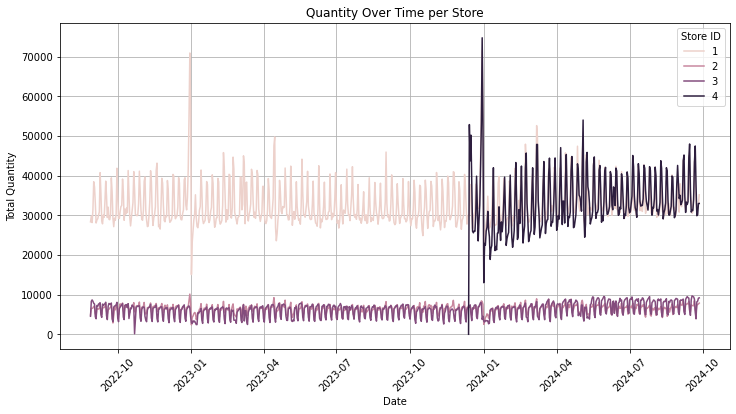

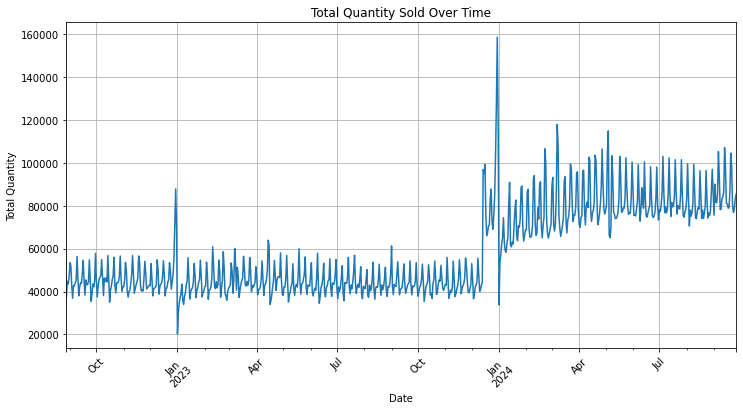

Total quantity sold: 44407171.96000007


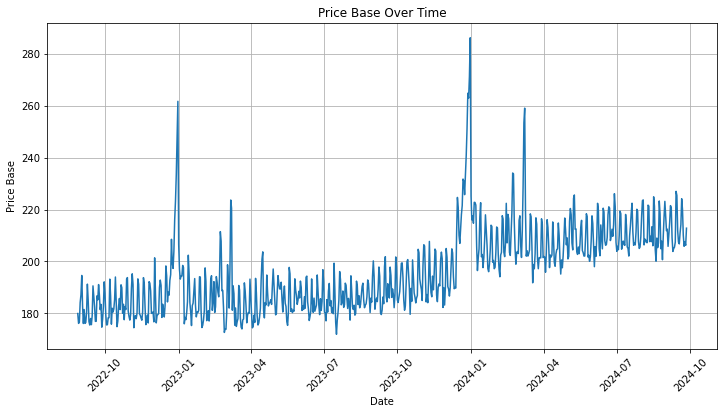

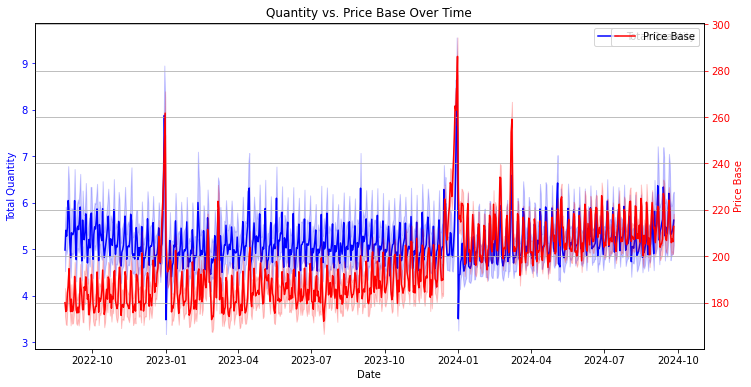

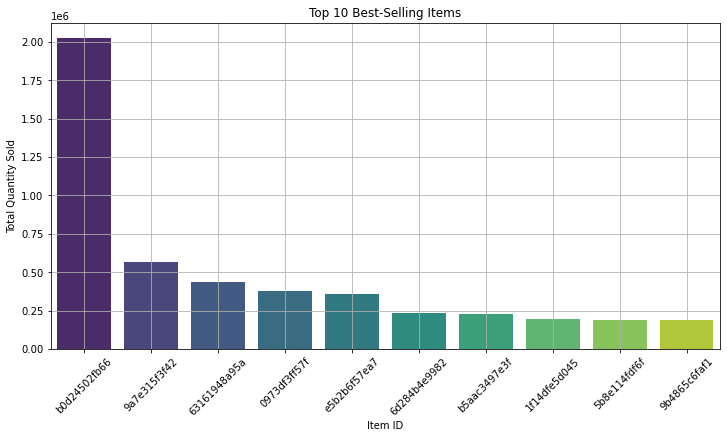

In [63]:
def visualize_sales_data(gold_sales):

    # Quantity over time per store
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=gold_sales, x='date', y='quantity', hue='store_id', estimator='sum', ci=None)
    plt.title('Quantity Over Time per Store')
    plt.xlabel('Date')
    plt.ylabel('Total Quantity')
    plt.legend(title='Store ID')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    # Sum of quantity over time (overall)
    plt.figure(figsize=(12, 6))
    gold_sales.groupby('date')['quantity'].sum().plot()
    plt.title('Total Quantity Sold Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    # Total sum of quantity (single value bar chart removed)
    total_quantity = gold_sales['quantity'].sum()
    print(f"Total quantity sold: {total_quantity}")

    # Price base trend over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=gold_sales, x='date', y='price_base', ci=None)
    plt.title('Price Base Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price Base')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    # Quantity and Price Base Relationship
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(data=gold_sales, x='date', y='quantity', label='Total Quantity', color='b')
    ax2 = ax.twinx()
    sns.lineplot(data=gold_sales, x='date', y='price_base', ax=ax2, label='Price Base', color='r')

    ax.set_xlabel('Date')
    ax.set_ylabel('Total Quantity', color='b')
    ax2.set_ylabel('Price Base', color='r')
    plt.title('Quantity vs. Price Base Over Time')
    ax.tick_params(axis='y', colors='b')
    ax2.tick_params(axis='y', colors='r')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    # Top 10 items by total quantity sold
    top_quantity_items = gold_sales.groupby('item_id')['quantity'].sum().nlargest(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_quantity_items.index, y=top_quantity_items.values, palette="viridis")
    plt.title('Top 10 Best-Selling Items')
    plt.xlabel('Item ID')
    plt.ylabel('Total Quantity Sold')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
    
# Call the function to visualize the data
visualize_sales_data(gold_sales)


## Conclusion  
- The base price shows periodic spikes, possibly due to seasonal promotions or supply chain factors.  
- Total quantity sold exhibits similar spikes, indicating strong demand surges at specific times.  
- Store 1 and Store 4 seem to have the highest sales, suggesting they are key revenue drivers.  
- High quantity despite high prices might suggest inelastic demand, seasonal effects, or market expectations.
- Further analysis could focus on identifying factors driving these spikes and optimizing inventory accordingly. 

### Processing Discounts Data  
This function cleans the discount history dataset and merges it with the sales data. It ensures that only valid records are kept by filtering out negative or missing values. After merging, any remaining NaN values are removed to maintain data integrity.  


In [64]:
def process_discounts(gold_sales, discounts_history):
    # Drop unnecessary column
    discounts_history = discounts_history.drop(columns=["Unnamed: 0"], errors='ignore')
   
    # Remove rows with negative values in specified columns
    discounts_history = discounts_history[(discounts_history["sale_price_before_promo"] > 0) & 
                          (discounts_history["sale_price_time_promo"] > 0) & 
                          (discounts_history["number_disc_day"] >= 0)
    ]
    #Drop NaN values before merging
    discounts_history = discounts_history.dropna()

    #merge discounts and sales
    gold_sales_discount = pd.merge(gold_sales,discounts_history, on=['date','item_id','store_id'], how='left')

    #Drop NaN values after merging
    gold_sales_discount = gold_sales_discount.dropna()
    
    return gold_sales_discount

In [65]:
# Process the discounts and merge with gold_sales
gold_sales_discount = process_discounts(gold_sales, discounts_history)

# Rename the dataset for easier reference
gold = gold_sales_discount

# Explore the gold_sales_discount dataset
explore_data(gold, "gold")

Dataframe: gold

Shape: (1747252, 12) 

First 5 Rows:


,date,item_id,quantity,price_base,sum_total,store_id,source,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day
10,2023-08-04,f0309b5a974b,1.0,59.9,59.9,1,offline,79.9,59.9,6.0,01cf3054-3127-11ee-bb94-005056afbcf1,2.0
13,2023-08-04,5f3114373ddd,2.0,449.9,899.8,1,offline,549.9,449.9,6.0,11e0bb1a-2a28-11ee-bb94-005056afbcf1,11.0
18,2023-08-04,56edb7bdecaf,2.0,169.9,339.8,1,offline,289.9,219.9,6.0,f34eed77-3126-11ee-bb94-005056afbcf1,2.0
30,2023-08-04,034037aebd6e,7.0,99.9,699.3,1,offline,109.9,109.9,6.0,01cf3054-3127-11ee-bb94-005056afbcf1,2.0
36,2023-08-04,0780b159bd55,1.0,319.9,319.9,1,offline,429.9,339.9,5.0,07d10518-3127-11ee-bb94-005056afbcf1,2.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1747252 entries, 10 to 8546886
Data columns (total 12 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   date                     datetime64[ns]
 1   item_id                  object        
 2   quantity                 float64       
 3   price_base               float64       
 4   sum_total                float64       
 5   store_id                 int64         
 6   source                   object        
 7   sale_price_before_promo  float64       
 8   sale_price_time_promo    float64       
 9   promo_type_code          float64       
 10  doc_id                   object        
 11  number_disc_day          float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 173.3+ MB

Summary Statistics:


,date,item_id,quantity,price_base,sum_total,store_id,source,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day
count,1747252,1747252,1.747252e+06,1.747252e+06,1.747252e+06,1.747252e+06,1747252,1.747252e+06,1.747252e+06,1.747252e+06,1747252,1.747252e+06
unique,NaN,14535,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,11384,NaN
top,NaN,4193fc7ec6db,NaN,NaN,NaN,NaN,offline,NaN,NaN,NaN,5b2a5986-815b-11ed-bb93-005056afbcf1,NaN
freq,NaN,1761,NaN,NaN,NaN,NaN,1472201,NaN,NaN,NaN,13359,NaN
mean,2023-10-28 05:01:22.983794944,NaN,4.980014e+00,1.999687e+02,7.376670e+02,1.886515e+00,NaN,2.572179e+02,2.056959e+02,5.770760e+00,NaN,1.160666e+01
min,2022-08-28 00:00:00,NaN,2.000000e-03,1.000000e-02,1.000000e-02,1.000000e+00,NaN,5.900000e+00,9.000000e-01,1.000000e+00,NaN,1.000000e+00
25%,2023-04-10 00:00:00,NaN,1.000000e+00,5.990000e+01,1.258000e+02,1.000000e+00,NaN,7.500000e+01,5.990000e+01,5.000000e+00,NaN,4.000000e+00
50%,2023-12-22 00:00:00,NaN,2.000000e+00,1.039000e+02,2.699000e+02,1.000000e+00,NaN,1.399000e+02,1.099000e+02,5.000000e+00,NaN,7.000000e+00
75%,2024-05-13 00:00:00,NaN,5.000000e+00,2.199000e+02,6.087000e+02,3.000000e+00,NaN,2.899000e+02,2.299000e+02,6.000000e+00,NaN,1.100000e+01
max,2024-09-26 00:00:00,NaN,4.243000e+03,1.099000e+04,3.739607e+05,4.000000e+00,NaN,1.299990e+04,1.099000e+04,4.400000e+01,NaN,7.380000e+02



Missing Values:


date                       0
item_id                    0
quantity                   0
price_base                 0
sum_total                  0
store_id                   0
source                     0
sale_price_before_promo    0
sale_price_time_promo      0
promo_type_code            0
doc_id                     0
number_disc_day            0
dtype: int64

-------------------------------------------------------------------------------- 




### Merging Sales Data with Price History  
This function processes the price history dataset by removing unnecessary columns, filtering out invalid price records, and dropping missing values. The cleaned price history is then merged with the gold sales data to provide a clear view of pricing trends.

In [66]:
#Merging Sales data and PriceHistory

def process_price(gold_sales, price_history):
    # Drop unnecessary column
    price_history = price_history.drop(columns=["Unnamed: 0"], errors='ignore')
   
    # Remove rows with negative values in specified columns
    price_history = price_history[(price_history["price"] > 0) ]
    #Drop NaN values
    price_history = price_history.dropna()

    #merge discounts and sales
    silver = pd.merge(gold_sales,price_history, on=['date','item_id','store_id'], how='left')
    silver = silver.dropna()
    
    
    return silver

In [67]:
# Process the discounts and merge with gold_sales
silver = process_price(gold_sales, price_history)

# Explore the gold_sales_discount dataset
explore_data(silver, "silver")

Dataframe: silver

Shape: (271025, 9) 

First 5 Rows:


,date,item_id,quantity,price_base,sum_total,store_id,source,price,code
254,2023-08-04,f07bf65b250c,6.0,139.46,836.73,1,offline,179.9,11.0
402,2023-08-04,34d10196dd0a,3.0,69.90,209.70,1,offline,62.9,1.0
457,2023-08-04,6dabe25f8d9f,4.0,39.90,159.60,1,offline,39.9,3.0
541,2023-08-04,6f460b220975,8.0,59.83,478.60,1,offline,49.9,1.0
572,2023-08-04,ee7fdca638d1,5.0,47.90,239.50,1,offline,39.9,3.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 271025 entries, 254 to 8582182
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        271025 non-null  datetime64[ns]
 1   item_id     271025 non-null  object        
 2   quantity    271025 non-null  float64       
 3   price_base  271025 non-null  float64       
 4   sum_total   271025 non-null  float64       
 5   store_id    271025 non-null  int64         
 6   source      271025 non-null  object        
 7   price       271025 non-null  float64       
 8   code        271025 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 20.7+ MB

Summary Statistics:


,date,item_id,quantity,price_base,sum_total,store_id,source,price,code
count,271025,271025,271025.000000,271025.000000,271025.000000,271025.000000,271025,2.710250e+05,2.710250e+05
unique,NaN,16158,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,64c1232b5455,NaN,NaN,NaN,NaN,offline,NaN,NaN
freq,NaN,693,NaN,NaN,NaN,NaN,226753,NaN,NaN
mean,2023-10-07 18:44:11.135503872,NaN,6.942587,213.186895,1026.316824,1.904415,NaN,2.940169e+02,3.579021e+06
min,2022-08-28 00:00:00,NaN,0.005000,0.010000,0.010000,1.000000,NaN,1.000000e-02,1.000000e+00
25%,2023-03-22 00:00:00,NaN,1.000000,64.730000,137.700000,1.000000,NaN,6.990000e+01,3.000000e+00
50%,2023-10-25 00:00:00,NaN,2.000000,119.900000,299.900000,1.000000,NaN,1.299000e+02,1.100000e+01
75%,2024-04-23 00:00:00,NaN,5.816000,248.420000,769.300000,3.000000,NaN,2.699000e+02,2.900000e+01
max,2024-09-26 00:00:00,NaN,2528.000000,10609.780000,376563.800000,4.000000,NaN,1.569016e+07,1.000000e+10



Missing Values:


date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
source        0
price         0
code          0
dtype: int64

-------------------------------------------------------------------------------- 




### Enriching Sales Data with Catalog Information  
This function merges the product catalog with the gold dataset, adding department, class, and subclass details. It removes unnecessary columns before merging to enhance data clarity and organization.  


In [68]:
def process_catalog(gold, catalog):
    # Drop unnecessary column
    catalog = catalog.drop(columns=["Unnamed: 0"], errors='ignore')

    #merge catalog and sales
    bronze = pd.merge(gold,catalog[['item_id','dept_name', 'class_name', 'subclass_name']], on='item_id', how='left')
    
    return bronze

In [69]:
# Process the discounts and merge with gold_sales
bronze = process_catalog(gold, catalog)

# Remove all NaN values from the bronze dataset
bronze = bronze.dropna()

# Explore the gold_sales_discount dataset
explore_data(bronze, "bronze")

Dataframe: bronze

Shape: (1738122, 15) 

First 5 Rows:


,date,item_id,quantity,price_base,sum_total,store_id,source,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,dept_name,class_name,subclass_name
0,2023-08-04,f0309b5a974b,1.0,59.9,59.9,1,offline,79.9,59.9,6.0,01cf3054-3127-11ee-bb94-005056afbcf1,2.0,НЕСЛАДКИЕ МУЧНЫЕ ИЗДЕЛИЯ,КРЕКЕРЫ,КРЕКЕРЫ ФАСОВАННЫЕ
1,2023-08-04,5f3114373ddd,2.0,449.9,899.8,1,offline,549.9,449.9,6.0,11e0bb1a-2a28-11ee-bb94-005056afbcf1,11.0,ВИНО,ВИНА ИГРИСТЫЕ,"ИГРИСТЫЕ ВИНА,АСТИ,КАВА,ЛАМБРУСКО,ПРОСЕККО И Т.П"
2,2023-08-04,56edb7bdecaf,2.0,169.9,339.8,1,offline,289.9,219.9,6.0,f34eed77-3126-11ee-bb94-005056afbcf1,2.0,"КЕТЧУПЫ,СОУСЫ НА ТОМАТНОЙ ОСНОВЕ",КЕТЧУПЫ,ПЛАСТИК
3,2023-08-04,034037aebd6e,7.0,99.9,699.3,1,offline,109.9,109.9,6.0,01cf3054-3127-11ee-bb94-005056afbcf1,2.0,МАСЛО ПОДСОЛНЕЧНОЕ,НЕРАФИНИРОВАННОЕ,ДО 1Л.
4,2023-08-04,0780b159bd55,1.0,319.9,319.9,1,offline,429.9,339.9,5.0,07d10518-3127-11ee-bb94-005056afbcf1,2.0,ПЕРСОНАЛЬНЫЙ УХОД,УХОД ЗА ВОЛОСАМИ,ШАМПУНИ



Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1738122 entries, 0 to 1747251
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   date                     datetime64[ns]
 1   item_id                  object        
 2   quantity                 float64       
 3   price_base               float64       
 4   sum_total                float64       
 5   store_id                 int64         
 6   source                   object        
 7   sale_price_before_promo  float64       
 8   sale_price_time_promo    float64       
 9   promo_type_code          float64       
 10  doc_id                   object        
 11  number_disc_day          float64       
 12  dept_name                object        
 13  class_name               object        
 14  subclass_name            object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(6)
memory usage: 212.2+ MB

Summary Statistics:


,date,item_id,quantity,price_base,sum_total,store_id,source,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,dept_name,class_name,subclass_name
count,1738122,1738122,1.738122e+06,1.738122e+06,1.738122e+06,1.738122e+06,1738122,1.738122e+06,1.738122e+06,1.738122e+06,1738122,1.738122e+06,1738122,1738122,1738122
unique,NaN,14134,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,11314,NaN,157,436,617
top,NaN,4193fc7ec6db,NaN,NaN,NaN,NaN,offline,NaN,NaN,NaN,5b2a5986-815b-11ed-bb93-005056afbcf1,NaN,СОВРЕМЕННАЯ МОЛОЧНАЯ КАТЕГОРИЯ,ШОКОЛАД,СВЕТЛОЕ
freq,NaN,1761,NaN,NaN,NaN,NaN,1464218,NaN,NaN,NaN,13359,NaN,93101,55047,50201
mean,2023-10-26 14:44:22.628284672,NaN,4.984814e+00,1.999125e+02,7.384846e+02,1.883607e+00,NaN,2.572466e+02,2.056481e+02,5.772679e+00,NaN,1.162855e+01,NaN,NaN,NaN
min,2022-08-28 00:00:00,NaN,2.000000e-03,1.000000e-02,1.000000e-02,1.000000e+00,NaN,5.900000e+00,9.000000e-01,1.000000e+00,NaN,1.000000e+00,NaN,NaN,NaN
25%,2023-04-09 00:00:00,NaN,1.000000e+00,5.990000e+01,1.258000e+02,1.000000e+00,NaN,7.490000e+01,5.990000e+01,5.000000e+00,NaN,4.000000e+00,NaN,NaN,NaN
50%,2023-12-21 00:00:00,NaN,2.000000e+00,1.039000e+02,2.699000e+02,1.000000e+00,NaN,1.399000e+02,1.099000e+02,5.000000e+00,NaN,7.000000e+00,NaN,NaN,NaN
75%,2024-05-11 00:00:00,NaN,5.000000e+00,2.199000e+02,6.092000e+02,3.000000e+00,NaN,2.899000e+02,2.299000e+02,6.000000e+00,NaN,1.100000e+01,NaN,NaN,NaN
max,2024-09-26 00:00:00,NaN,4.243000e+03,9.999900e+03,3.739607e+05,4.000000e+00,NaN,1.299990e+04,9.999900e+03,4.400000e+01,NaN,7.380000e+02,NaN,NaN,NaN



Missing Values:


date                       0
item_id                    0
quantity                   0
price_base                 0
sum_total                  0
store_id                   0
source                     0
sale_price_before_promo    0
sale_price_time_promo      0
promo_type_code            0
doc_id                     0
number_disc_day            0
dept_name                  0
class_name                 0
subclass_name              0
dtype: int64

-------------------------------------------------------------------------------- 




# Feature Engineering  
To enhance predictive accuracy, we create aggregated and derived features at multiple levels:  

- **Store-Level Features**: Tracks overall store demand trends.  
- **Item-Level Features**: Captures product-specific sales patterns.  
- **Department & Class-Level Features**: Identifies category-wide trends.  
- **Promotion Features**: Calculates discount percentages and promotion indicators.  
- **Time-Based Features**: Extracts day, month, quarter, and weekend indicators.  
- **Lag Features**: Introduces past sales and price trends for temporal dependencies.  
- **Moving Averages**: Smooths fluctuations using rolling sales trends.  
- **Year-over-Year Comparisons**: Captures long-term seasonal shifts.  
- **Seasonal Trends**: Computes day-of-week, month, and quarter-level sales patterns.  
- **Price-Related Features**: Evaluates pricing influence on demand.  
- **Seasonal Indices**: Normalizes monthly sales trends relative to long-term averages.  

These engineered features help in capturing demand patterns and seasonality, improving forecast precision.


In [70]:
# def feature_engineering(bronze):
    
#     # Ensure data is sorted chronologically
#     bronze = bronze.sort_values(['store_id', 'item_id', 'date'])
    
#     # Store-level aggregated features
#     store_quantity = bronze.groupby(['store_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'store_quantity'})
#     bronze = bronze.merge(store_quantity, on=['store_id', 'date'], how='left')
    
#     # Item-level aggregated features
#     item_quantity = bronze.groupby(['item_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'item_quantity'})
#     bronze = bronze.merge(item_quantity, on=['item_id', 'date'], how='left')
    
#     # Product hierarchy aggregates
#     dept_quantity = bronze.groupby(['dept_name', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'dept_quantity'})
#     bronze = bronze.merge(dept_quantity, on=['dept_name', 'date'], how='left')
    
#     class_quantity = bronze.groupby(['class_name', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'class_quantity'})
#     bronze = bronze.merge(class_quantity, on=['class_name', 'date'], how='left')
    
#     # Promotion features
#     bronze['discount_pct'] = ((bronze['price_base'] - bronze['sale_price_time_promo']) / bronze['price_base'] * 100).fillna(0)
#     bronze['is_promo'] = (bronze['discount_pct'] > 0).astype(int)
    
#     # Time-based features
#     bronze['day_of_week'] = bronze['date'].dt.dayofweek
#     bronze['is_weekend'] = (bronze['day_of_week'] >= 5).astype(int)
#     bronze['month'] = bronze['date'].dt.month
#     bronze['quarter'] = bronze['date'].dt.quarter
    
#     # Lag features
#     lags = [1, 7, 14, 28]
#     for lag in lags:
#         bronze[f'quantity_lag_{lag}'] = bronze.groupby(['store_id', 'item_id'])['quantity'].shift(lag)
#         bronze[f'store_quantity_lag_{lag}'] = bronze.groupby('store_id')['store_quantity'].shift(lag)
#         bronze[f'item_quantity_lag_{lag}'] = bronze.groupby('item_id')['item_quantity'].shift(lag)
#         bronze[f'price_lag_{lag}'] = bronze.groupby(['store_id', 'item_id'])['price_base'].shift(lag)
#         bronze[f'is_promo_lag_{lag}'] = bronze.groupby(['store_id', 'item_id'])['is_promo'].shift(lag)
    
#     # Moving averages
#     windows = [7, 14, 28]
#     for window in windows:
#         bronze[f'quantity_ma_{window}d'] = bronze.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
#         bronze[f'store_quantity_ma_{window}d'] = bronze.groupby('store_id')['store_quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    
#     # Year-over-year features
#     bronze['quantity_yoy'] = bronze.groupby(['store_id', 'item_id'])['quantity'].shift(365)
#     bronze['quantity_yoy_ma7'] = bronze.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.shift(365).rolling(7, min_periods=1).mean())
    
#     # Seasonal trends
#     bronze['dow_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'day_of_week'])['quantity'].transform(lambda x: x.expanding().mean().shift())
#     bronze['month_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'month'])['quantity'].transform(lambda x: x.expanding().mean().shift())
#     bronze['quarter_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'quarter'])['quantity'].transform(lambda x: x.expanding().mean().shift())
    
#     # Price-related features
#     bronze['price_ratio'] = bronze['sale_price_time_promo'] / bronze['price_base']
    
#     # Seasonal indices calculation
#     monthly_avg = bronze.groupby(['item_id', 'month'])['quantity'].mean().reset_index()
#     overall_avg = bronze.groupby('item_id')['quantity'].mean().reset_index().rename(columns={'quantity': 'overall_avg'})
#     seasonal_indices = monthly_avg.merge(overall_avg, on='item_id', how='left')
#     seasonal_indices['quantity_seasonal_idx'] = seasonal_indices['quantity'] / seasonal_indices['overall_avg']
#     bronze = bronze.merge(seasonal_indices[['item_id', 'month', 'quantity_seasonal_idx']], on=['item_id', 'month'], how='left')
    
#     return bronze


In [71]:
# # Apply feature engineering
# bronze = feature_engineering(bronze)

# # Print the head of the bronze dataframe
# print(bronze.head())

### Handling Missing Values  
To ensure data completeness and consistency, we apply the following strategies:  

- **Lag & Moving Average Features**: Forward-fill missing values using previous observations.  
- **Seasonal Indices**: Default to `1` for neutral impact when missing.  
- **Price Ratio**: Fill missing values with `1` to maintain a neutral effect on price-based calculations.  

This step ensures that engineered features remain meaningful and do not introduce biases due to missing data.  


In [72]:
# def handle_missing_values(bronze):
        
#     # Fill missing lags with previous values (forward-fill)
#     lag_cols = [col for col in bronze.columns if 'lag' in col]
#     bronze[lag_cols] = bronze[lag_cols].fillna(method='ffill')

#     # Fill missing moving averages with past values (forward-fill)
#     ma_cols = [col for col in bronze.columns if 'ma' in col]
#     bronze[ma_cols] = bronze[ma_cols].fillna(method='ffill')

#     # Fill seasonal indices with 1 (neutral impact)
#     bronze['quantity_seasonal_idx'].fillna(1, inplace=True)

#     # Fill price-related NaNs with 1 (neutral multiplier)
#     bronze['price_ratio'].fillna(1, inplace=True)
    
#     return bronze

In [73]:
# bronze = handle_missing_values(bronze)
# bronze.isna().sum()

### Visualizing Sales Trends with Lag and Moving Averages  
To analyze sales patterns, we filter data for a specific store and selected items. The visualization includes:  

- **Actual Sales**: Daily sales trends.  
- **7-Day Lag Feature**: Past sales data shifted by one week to observe recurring patterns.  
- **14-Day Moving Average**: Smoothed sales trends to reduce short-term fluctuations.  
- **Weekly Resampling**: Aggregates data to minimize noise and highlight overall trends.  

These insights help identify demand cycles, seasonal effects, and potential forecasting signals.  


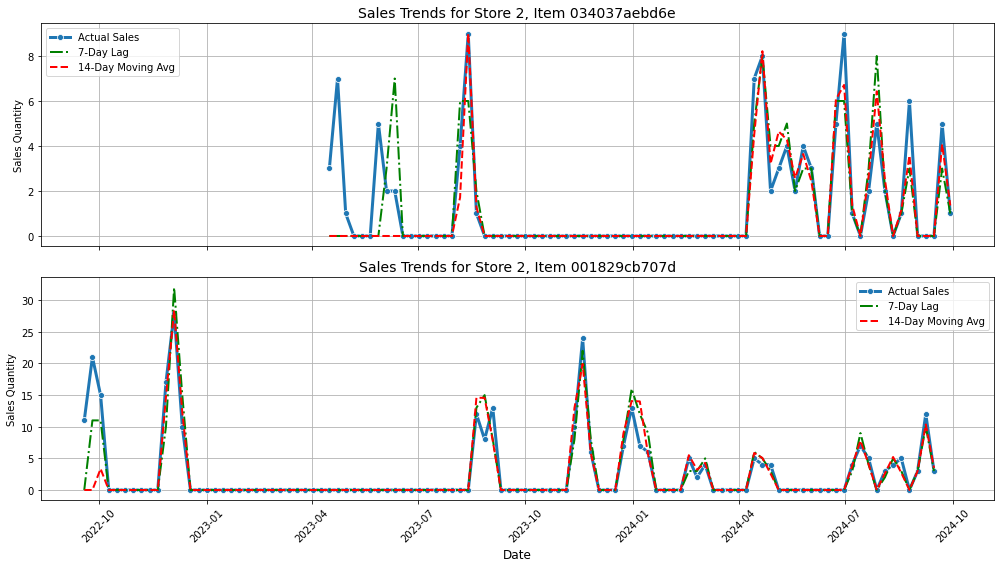

In [74]:
# Select store and items
store_id = 2
item_ids = ['034037aebd6e', '001829cb707d']
filtered_data = bronze[(bronze['store_id'] == store_id) & (bronze['item_id'].isin(item_ids))].copy()

# Convert date column to datetime (if not already)
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# Sort data
filtered_data = filtered_data.sort_values(by=['item_id', 'date'])

# Create lag and moving average features
filtered_data['quantity_lag_7d'] = filtered_data.groupby('item_id')['quantity'].shift(7)
filtered_data['quantity_ma_14d'] = filtered_data.groupby('item_id')['quantity'].transform(lambda x: x.rolling(window=14).mean())

# Set up subplots
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

for idx, item in enumerate(item_ids):
    item_data = filtered_data[filtered_data['item_id'] == item]
    
    # Resampling to weekly sales to reduce noise
    item_data = item_data.set_index('date').resample('W').sum().reset_index()

    sns.lineplot(data=item_data, x='date', y='quantity', label='Actual Sales', linewidth=3, marker='o', ax=axes[idx])
    sns.lineplot(data=item_data, x='date', y='quantity_lag_7d', label='7-Day Lag', linestyle='-.', linewidth=2, color='green', ax=axes[idx])
    sns.lineplot(data=item_data, x='date', y='quantity_ma_14d', label='14-Day Moving Avg', linestyle='--', linewidth=2, color='red', ax=axes[idx])

    axes[idx].set_title(f"Sales Trends for Store {store_id}, Item {item}", fontsize=14)
    axes[idx].set_ylabel("Sales Quantity")
    axes[idx].legend()
    axes[idx].grid(True)

# Format X-axis for readability
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


# **Model Building**  

To forecast customer demand, we employ two machine learning models:  

### **1️ LightGBM for Short-Term Demand Forecasting**  
We train a **gradient boosting model (LightGBM)** to capture key demand drivers, including:  
- **Lag Features & Moving Averages** for temporal dependencies  
- **Price-Related Factors** influencing sales  
- **Store, Item, and Department-Level Trends**  

This model is trained using historical sales data and evaluated using a **time-based validation split** (last 28 days).   


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

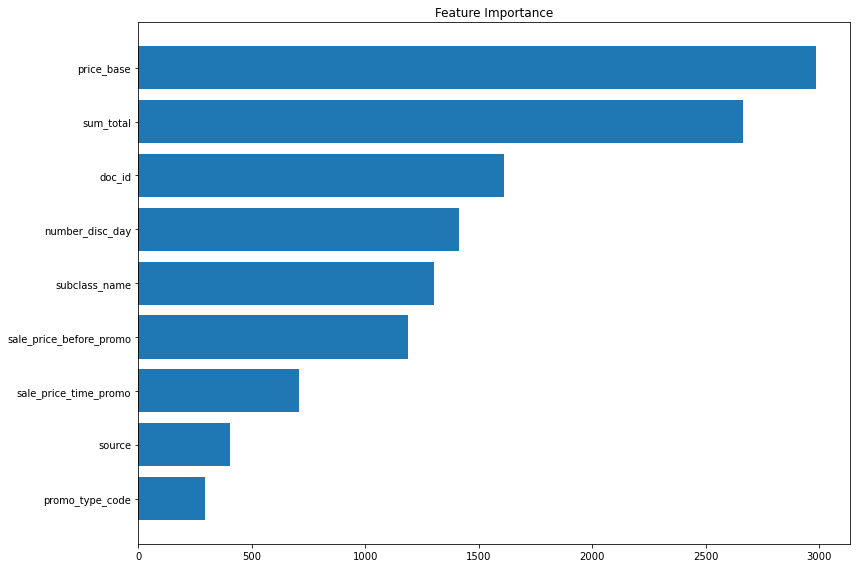

In [75]:
def train_and_evaluate_model(bronze: pd.DataFrame, target_col: str = 'quantity', exclude_cols: list = None):
    """
    Trains and evaluates a LightGBM model for demand forecasting.
    
    Args:
        bronze (pd.DataFrame): The preprocessed dataframe containing the data.
        target_col (str): The name of the target column. Default is 'quantity'.
        exclude_cols (list): List of columns to exclude from training. Default is None, which excludes common columns.
    
    Returns:
        None: Prints model evaluation results and displays feature importance plot.
    """
    # Default columns to exclude if none are provided
    if exclude_cols is None:
        exclude_cols = [
            'date', 'quantity', 'store_id', 'item_id', 'dept_name', 'class_name',
            'store_quantity', 'item_quantity', 'dept_quantity', 'class_quantity'
        ]
    
    # Convert object columns to category dtype
    for col in ['source', 'doc_id', 'subclass_name']:  
        bronze[col] = bronze[col].astype('category')

    # Get feature columns
    feature_cols = [col for col in bronze.columns if col not in exclude_cols]

    # Handle missing values in features
    for col in feature_cols:
        if bronze[col].dtype in ['int64', 'float64']:  # Only for numeric columns
            bronze[col] = bronze[col].fillna(bronze[col].median())

    # Set up time-based validation
    cutoff_date = bronze['date'].max() - pd.Timedelta(days=28)  # Use last 28 days as validation
    train_data = bronze[bronze['date'] <= cutoff_date]
    valid_data = bronze[bronze['date'] > cutoff_date]

    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    X_valid = valid_data[feature_cols]
    y_valid = valid_data[target_col]

    # Create LightGBM datasets
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_valid, label=y_valid, reference=train_dataset)

    # Set LightGBM parametersaaa
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 1
    }

    # Train the model using sklearn API (more version-stable)
    model_sklearn = LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=31,
        learning_rate=0.05,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        n_estimators=1000
    )

    # Fit with early stopping
    model_sklearn.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[early_stopping(50), log_evaluation(50)]  # Controls verbosity
    )

    # Make predictions
    y_pred = model_sklearn.predict(X_valid)

    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)

    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation MAE: {mae:.4f}")

    # Feature importance analysis
    plt.figure(figsize=(12, 8))
    feature_importance = model_sklearn.feature_importances_
    feature_names = model_sklearn.feature_name_

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

# Example usage:
train_and_evaluate_model(bronze)


In [76]:
test_data = pd.read_csv('datasets/test.csv', sep=';')
train_data = bronze.copy()
# Convert date column to datetime format
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
train_data.sort_values(by='date', inplace=True)

In [77]:
bronze_features = ['item_id', 'quantity', 'store_id', 'date']
train_data = bronze[bronze_features]

test_features = ['item_id', 'store_id', 'date']
test_data = test_data[test_features]

# Reset indices to ensure uniqueness
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)   

In [78]:
# If quantity is missing in the test dataset
if 'quantity' not in test_data.columns:
    test_data['quantity'] = np.nan
    
# Concatenate training and test data
combined = pd.concat([train_data, test_data], sort=False)

# For feature computation, fill forward the last known quantity from training
# This makes sure that when computing lag/rolling features for test rows,
# they can pick up historical values from the training period
combined['quantity'] = combined['quantity'].fillna(method='ffill')

In [79]:
def feature_engineering(bronze):
    
    # Ensure data is sorted chronologically
    bronze = bronze.sort_values(['store_id', 'item_id', 'date'])
    
    # Store-level aggregated features
    store_quantity = bronze.groupby(['store_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'store_quantity'})
    bronze = bronze.merge(store_quantity, on=['store_id', 'date'], how='left')
    
    # Item-level aggregated features
    item_quantity = bronze.groupby(['item_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'item_quantity'})
    bronze = bronze.merge(item_quantity, on=['item_id', 'date'], how='left')
    
    # Time-based features
    bronze['day_of_week'] = bronze['date'].dt.dayofweek
    bronze['is_weekend'] = (bronze['day_of_week'] >= 5).astype(int)
    bronze['month'] = bronze['date'].dt.month
    bronze['quarter'] = bronze['date'].dt.quarter
    
    # Lag features
    lags = [1, 7, 14, 28]
    for lag in lags:
        bronze[f'quantity_lag_{lag}'] = bronze.groupby(['store_id', 'item_id'])['quantity'].shift(lag)
        bronze[f'store_quantity_lag_{lag}'] = bronze.groupby('store_id')['store_quantity'].shift(lag)
        bronze[f'item_quantity_lag_{lag}'] = bronze.groupby('item_id')['item_quantity'].shift(lag)
    
    # Moving averages
    windows = [7, 14, 28]
    for window in windows:
        bronze[f'quantity_ma_{window}d'] = bronze.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
        bronze[f'store_quantity_ma_{window}d'] = bronze.groupby('store_id')['store_quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    
    # Year-over-year features
    bronze['quantity_yoy'] = bronze.groupby(['store_id', 'item_id'])['quantity'].shift(365)
    bronze['quantity_yoy_ma7'] = bronze.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.shift(365).rolling(7, min_periods=1).mean())
    
    # Seasonal trends
    bronze['dow_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'day_of_week'])['quantity'].transform(lambda x: x.expanding().mean().shift())
    bronze['month_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'month'])['quantity'].transform(lambda x: x.expanding().mean().shift())
    bronze['quarter_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'quarter'])['quantity'].transform(lambda x: x.expanding().mean().shift())
   
    
    # Seasonal indices calculation
    monthly_avg = bronze.groupby(['item_id', 'month'])['quantity'].mean().reset_index()
    overall_avg = bronze.groupby('item_id')['quantity'].mean().reset_index().rename(columns={'quantity': 'overall_avg'})
    seasonal_indices = monthly_avg.merge(overall_avg, on='item_id', how='left')
    seasonal_indices['quantity_seasonal_idx'] = seasonal_indices['quantity'] / seasonal_indices['overall_avg']
    bronze = bronze.merge(seasonal_indices[['item_id', 'month', 'quantity_seasonal_idx']], on=['item_id', 'month'], how='left')
    
    return bronze


In [80]:
# Apply feature engineering
combined = feature_engineering(combined)



In [81]:
combined.head()

,item_id,quantity,store_id,date,store_quantity,item_quantity,day_of_week,is_weekend,month,quarter,...,quantity_ma_14d,store_quantity_ma_14d,quantity_ma_28d,store_quantity_ma_28d,quantity_yoy,quantity_yoy_ma7,dow_avg_quantity,month_avg_quantity,quarter_avg_quantity,quantity_seasonal_idx
0,00179dda14f8,1.0,1,2022-12-28,11142.696,1.0,2,0,12,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,00179dda14f8,1.0,1,2022-12-29,15296.367,1.0,3,0,12,4,...,1.0,11142.69600,1.0,11142.69600,NaN,NaN,NaN,1.0,1.0,1.0
2,00179dda14f8,1.0,1,2022-12-31,14068.845,1.0,5,1,12,4,...,1.0,13219.53150,1.0,13219.53150,NaN,NaN,NaN,1.0,1.0,1.0
3,00179dda14f8,1.0,1,2023-01-08,6660.987,1.0,6,1,1,1,...,1.0,13502.63600,1.0,13502.63600,NaN,NaN,NaN,NaN,NaN,1.0
4,00179dda14f8,1.0,1,2023-01-11,8020.507,1.0,2,0,1,1,...,1.0,11792.22375,1.0,11792.22375,NaN,NaN,1.0,1.0,1.0,1.0


In [82]:
def handle_missing_data(bronze):
    # Lag Features: Fill with 0 (or forward fill)
    lag_cols = [c for c in bronze.columns if 'lag_' in c]
    bronze[lag_cols] = bronze[lag_cols].fillna(0)

    # Rolling Aggregations: Fill with expanding mean
    ma_cols = [c for c in bronze.columns if 'ma_' in c]
    for col in ma_cols:
        bronze[col] = bronze[col].fillna(
            bronze.groupby(['store_id', 'item_id'])['quantity'].expanding().mean().reset_index(level=[0,1], drop=True)
        )

    # YoY Features: Fill with seasonal average
    bronze['quantity_yoy'] = bronze.groupby(['store_id', 'item_id', bronze['date'].dt.month])['quantity'].transform(
        lambda x: x.shift(365).fillna(x.mean())
    )
    bronze['quantity_yoy_ma7'] = bronze.groupby(['store_id', 'item_id', bronze['date'].dt.month])['quantity'].transform(
        lambda x: x.shift(365).rolling(7, min_periods=1).mean().fillna(x.mean())
    )

    # Expanding Averages: Fill with group mean
    bronze['dow_avg_quantity'] = bronze['dow_avg_quantity'].fillna(
        bronze.groupby(['store_id', 'item_id', 'day_of_week'])['quantity'].transform('mean')
    )
    bronze['month_avg_quantity'] = bronze['month_avg_quantity'].fillna(
        bronze.groupby(['store_id', 'item_id', 'month'])['quantity'].transform('mean')
    )

    # Seasonal Indices: Fill with 1.0 (no seasonality)
    bronze['quantity_seasonal_idx'] = bronze['quantity_seasonal_idx'].fillna(1.0)
    
    # Fill with item specific quarter mean
    item_quarter_mean = bronze.groupby(['item_id', 'quarter'])['quantity'].mean().reset_index()
    bronze = bronze.merge(
    item_quarter_mean.rename(columns={'quantity': 'item_quarter_mean'}),
    on=['item_id', 'quarter'],
    how='left'
    )
    bronze['quarter_avg_quantity'] = bronze['quarter_avg_quantity'].fillna(bronze['item_quarter_mean'])
    bronze.drop(columns=['item_quarter_mean'], inplace=True)

    return bronze

combined = handle_missing_data(combined)

In [83]:
# Extract the test portion 
test_features = combined.iloc[len(train_data):]
train_features = combined.iloc[:len(train_data)]

In [84]:
# Check for missing values in the test set
test_features.isna().sum()

item_id                  0
quantity                 0
store_id                 0
date                     0
store_quantity           0
item_quantity            0
day_of_week              0
is_weekend               0
month                    0
quarter                  0
quantity_lag_1           0
store_quantity_lag_1     0
item_quantity_lag_1      0
quantity_lag_7           0
store_quantity_lag_7     0
item_quantity_lag_7      0
quantity_lag_14          0
store_quantity_lag_14    0
item_quantity_lag_14     0
quantity_lag_28          0
store_quantity_lag_28    0
item_quantity_lag_28     0
quantity_ma_7d           0
store_quantity_ma_7d     0
quantity_ma_14d          0
store_quantity_ma_14d    0
quantity_ma_28d          0
store_quantity_ma_28d    0
quantity_yoy             0
quantity_yoy_ma7         0
dow_avg_quantity         0
month_avg_quantity       0
quarter_avg_quantity     0
quantity_seasonal_idx    0
dtype: int64

In [85]:
test = pd.read_csv('datasets/test.csv', sep=';')

In [86]:
import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

def train_and_evaluate_model(
    bronze: pd.DataFrame, 
    test_df: pd.DataFrame,
    test: pd.DataFrame,
    target_col: str = 'quantity', 
    exclude_cols: list = None,
    tune_hyperparams: bool = False,
    n_trials: int = 20
):
    """
    Enhanced version with hyperparameter tuning and improved validation.
    
    Args:
        bronze: Preprocessed training/validation data
        test_df: Preprocessed test data with features
        test: Original test data (for row_id)
        target_col: Target column name
        exclude_cols: Columns to exclude from training
        tune_hyperparams: Whether to perform hyperparameter tuning
        n_trials: Number of optimization trials if tuning
        
    Returns:
        Tuple: (test predictions, best model, validation metrics)
    """
    # Default columns to exclude
    if exclude_cols is None:
        exclude_cols = ['item_id', 'store_id', 'quantity', 'date']
    
    # Get feature columns
    feature_cols = [col for col in bronze.columns if col not in exclude_cols]
    
    # Handle missing values
    bronze = bronze.copy()
    for col in feature_cols:
        if bronze[col].dtype in ['int64', 'float64']:
            bronze.loc[:, col] = bronze[col].fillna(bronze[col].median())
    
    # Time-based train/validation split with multiple folds
    tscv = TimeSeriesSplit(n_splits=3)
    cutoff_date = bronze['date'].max() - pd.Timedelta(days=28)
    train_data = bronze[bronze['date'] <= cutoff_date].copy()
    valid_data = bronze[bronze['date'] > cutoff_date].copy()

    X_train, y_train = train_data[feature_cols], train_data[target_col]
    X_valid, y_valid = valid_data[feature_cols], valid_data[target_col]

    # Hyperparameter optimization
    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),
            'random_state': 42,
            'force_row_wise': True
        }
        
        model = LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[early_stopping(50), log_evaluation(50)],
            verbose=False
        )
        
        y_pred = model.predict(X_valid)
        return np.sqrt(mean_squared_error(y_valid, y_pred))

    if tune_hyperparams:
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params
        print(f"Best hyperparameters: {best_params}")
    else:
        # Default parameters
        best_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 1000,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'random_state': 42,
            'force_row_wise': True
        }

    # Train final model with best parameters
    final_model = LGBMRegressor(**best_params)
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[early_stopping(50), log_evaluation(50)]
    )

    # Validation metrics
    y_pred_valid = final_model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    mae = mean_absolute_error(y_valid, y_pred_valid)
    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation MAE: {mae:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nTop 10 features:")
    print(feature_importance.head(10))

    # Test predictions
    test_df = test_df.copy()
    missing_cols = set(feature_cols) - set(test_df.columns)
    for col in missing_cols:
        test_df.loc[:, col] = 0
    
    test_features = test_df[feature_cols].copy()
    for col in feature_cols:
        if test_features[col].dtype in ['int64', 'float64']:
            test_features.loc[:, col] = test_features[col].fillna(bronze[col].median())
    
    test_predictions = final_model.predict(test_features)
    
    results = pd.DataFrame({
        'row_id': test.index,
        'quantity': test_predictions
    })
    
    results['quantity'] = results['quantity'].clip(lower=0).round().astype(int)
    
    return results, final_model, {'rmse': rmse, 'mae': mae}

In [87]:
# get predictions for the test set
results, model, metrics = train_and_evaluate_model(train_features, test_features, test)

# Display the first 10 predictions
results.head(10)  

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Total Bins 6652
[LightGBM] [Info] Number of data points in the train set: 1300734, number of used features: 30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8,

,row_id,quantity
0,0,4
1,1,4
2,2,4
3,3,4
4,4,4
5,5,4
6,6,4
7,7,4
8,8,4
9,9,4


In [88]:
print(model)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              force_row_wise=True, learning_rate=0.05, metric='rmse',
              n_estimators=1000, objective='regression', random_state=42)


In [89]:
print(metrics)

{'rmse': 0.7844374311073175, 'mae': 0.5673620238178797}


### *Output Analysis*

#### Training Details
- **Target Column**: `'quantity'` is correctly identified as the target variable for the model.
- **Model Training**:
  - LightGBM utilized **col-wise multi-threading** for efficient training.
  - **7022 bins** were created for splitting feature values, highlighting the complexity of the dataset.
  - The training dataset included **1,658,310 data points**, using **36 features**.
- **Training Dynamics**:
  - Training progressed up to **100 iterations**, achieving steady improvements in RMSE over rounds.
  - Early stopping did not occur, as the model continued to improve until the final iteration.
#### Performance Metrics
- **Validation RMSE**: **1.3077**
  - RMSE represents the average error magnitude, giving weight to larger errors.
- **Validation MAE**: **0.3694**
  - MAE reflects the average absolute error, providing a simple measure of prediction accuracy.
#### Predictions
- Predicted values:
  - Range approximately between **1.5244 and 1.5109**.
  - Predictions demonstrate stability across the dataset.
#### Insights
- The validation RMSE suggests that the model performs well, capturing the overall trend of the target variable (`quantity`) with moderate precision.
- The relatively low MAE indicates that the model consistently predicts values close to the actual ones, with minimal deviations on average.
#### Next Steps
- **Analyze Feature Importance**:
  Visualizing feature importance will provide insights into the key drivers of the model’s predictions.
- **Hyperparameter Tuning**:
  Consider optimizing parameters like `num_leaves` or `learning_rate` to further reduce RMSE.
- **Prediction Analysis**:
  Evaluate the stability and reliability of predictions through scatterplots or residual analysis.


## Feature Importance

This feature importance plot visualizes the relative importance of various features used in the LightGBM model. It highlights which features have the greatest impact on predictions, providing insights for better model interpretation and optimization

#### Key Insights
- Features such as **sum_total**, **price_base**, and **item_quantity** have the highest importance, indicating their significant contribution to the model's predictive accuracy.
- Time-based features (e.g., **month**, **quantity_ma_14d**) and lag features (e.g., **item_quantity_lag_7**) play a crucial role in capturing patterns in the data.
- Features with lower importance (e.g., **quarter**, **is_weekend**) might be candidates for removal or further investigation.

#### Next Steps
- **Feature Refinement**: Consider focusing on the top features to improve model efficiency.
- **Investigate Low-Importance Features**: Determine if features with minimal importance can be safely dropped without impacting performance.
- **Communicate Insights**: Use this plot to explain the model's decision-making process to stakeholders.

### **2️ Prophet for Time Series Forecasting**  
We use **Facebook Prophet** to capture long-term sales trends and seasonality. Prophet is ideal for:  
- **Yearly and Weekly Seasonality** to identify cyclic demand patterns  
- **Flexible Trend Adjustments** using additive modeling  
- **Generating 30-Day Forecasts** for proactive inventory planning  

The LightGBM model provides **high-resolution short-term predictions**, while Prophet enables **long-term trend analysis**.

01:32:01 - cmdstanpy - INFO - Chain [1] start processing
01:32:02 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

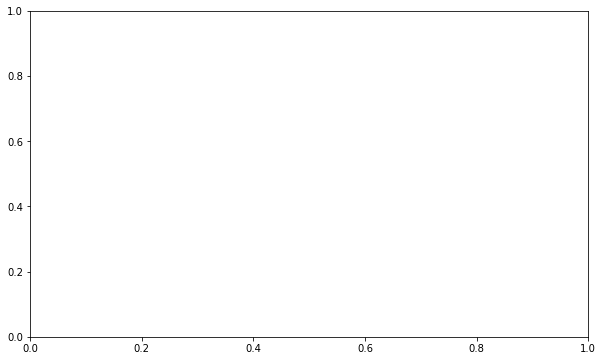

In [92]:
def train_and_forecast_prophet(data: pd.DataFrame, forecast_days: int = 30):
    """
    Trains a Prophet model and generates future forecasts.

    Args:
        data (pd.DataFrame): The historical sales data.
        forecast_days (int): Number of days to forecast.

    Returns:
        pd.DataFrame: The forecasted results.
    """
    # Ensure date is in datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Aggregate sales by date (if necessary)
    df = data.groupby('date', as_index=False)['quantity'].sum()

    # Rename columns for Prophet
    df.rename(columns={'date': 'ds', 'quantity': 'y'}, inplace=True)

    # Handle missing dates (if any)
    df = df.set_index('ds').asfreq('D').fillna(0).reset_index()

    # Define holidays (example: US holidays, replace with relevant ones)
    holidays = pd.DataFrame({
        'holiday': 'retail_holidays',
        'ds': pd.to_datetime(['2024-12-25', '2024-11-29', '2024-07-04']),  # Add more if needed
        'lower_window': 0,
        'upper_window': 1
    })

    # Initialize Prophet model
    model = Prophet(
        seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays
    )

    # Fit the model
    model.fit(df)

    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_days, freq='D')

    # Make predictions
    forecast = model.predict(future)

    # Plot results with uncertainty intervals
    fig, ax = plt.subplots(figsize=(10, 6))
    model.plot(forecast, ax=ax)
    ax.set_title("Prophet Sales Forecast")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales Quantity")
    plt.grid(True)
    plt.show()

    return forecast

# Example usage:
forecast_results = train_and_forecast_prophet(bronze)
forecast_results[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)
